In [1]:
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('chesterish')

# Biodiversity in National Parks
The goal of this project is to analyse the biodiversity data from the National Parks Service, especially about the endangered species in different parks.

This project will prepare, analyse and plot data to explain the findings.
 - What is the distribution of conservation_status for animals?
 - Are certain types of species more likely to be endangered?
 - Are the differences between species and their conservation status significant?
 - Which species were spotted the most at each park?

**Data:** `species_info.csv`, `observations.csv`

Note: The data for this project is inspired by real data, but is mostly 

In [89]:
## Import Python Modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### species

The `species_info.csv` contains information on the different species in the National Parks. The columns in the data set include:
- **category** - The category of taxonomy for each species
- **scientific_name** - The scientific name of each species
- **common_names** - The common names of each species
- **conservation_status** - The species conservation status


In [174]:
# Import the first csv file: species_info.csv and inspect the data
spc = pd.read_csv('species_info.csv', encoding='utf-8')
spc.fillna('No Intervention', inplace=True)
spc.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention
1,Mammal,Bos bison,"American Bison, Bison",No Intervention
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Intervention
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Intervention


In [145]:
spc.nunique()

category                  7
scientific_name        5541
common_names           5504
conservation_status       5
dtype: int64

In [176]:
# Fill NaN with 'No Intervention'
spc.fillna('No Intervention', inplace=True)

print('All categories: ', spc.category.unique())
print('All conversation status: ',  spc.conservation_status.unique())

All categories:  ['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']
All conversation status:  ['No Intervention' 'Species of Concern' 'Endangered' 'Threatened'
 'In Recovery']


#### observations

The `Observations.csv` contains information from recorded sightings of different species throughout the national parks in the past 7 days. The columns included are:

- **scientific_name** - The scientific name of each species
- **park_name** - The name of the national park
- **observations** - The number of observations in the past 7 days

In [139]:
# observations.csv
obs = pd.read_csv('observations.csv', encoding='utf-8')
obs.head()
# print(obs.nunique())

# print('All park names: ',  obs.park_name.unique())

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
Name: scientific_name, dtype: int64


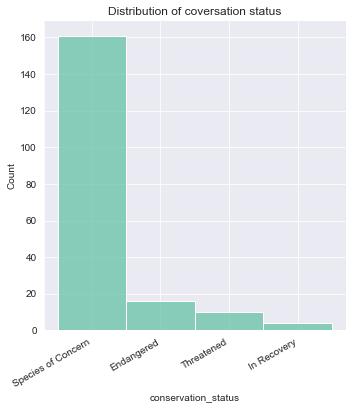

In [177]:
## What is the distribution of conservation_status for animals?
print(spc.groupby('conservation_status')['scientific_name'].size())

# Set color palette
sns.set_palette('Set2')
# Set style
sns.set_style('darkgrid')

c = sns.displot(data = spc[spc.conservation_status != 'No Intervention'], 
            x = 'conservation_status')
plt.title('Distribution of coversation status')
c.set_xticklabels(rotation = 30, horizontalalignment = 'right')
plt.show()

In [104]:
# Are certain types of species more likely to be endangered?
conversation_category = spc[spc.conservation_status != 'No Intervention'].\
      groupby(['conservation_status', 'category'])['scientific_name'].count().unstack()

conversation_category

# Mammal >> Bird >> Fish >> Amphibian, Plant

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


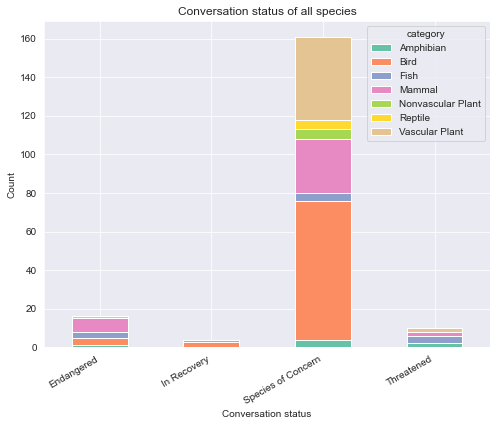

In [161]:
# Are the differences between species and their conservation status significant?
c = conversation_category.plot(kind = 'bar', figsize=(8,6), stacked=True)
plt.title('Conversation status of all species')
plt.xlabel('Conversation status')
plt.ylabel('Count')
c.set_xticklabels(c.get_xticklabels(), rotation = 30, horizontalalignment = 'right')
plt.show()

In [114]:
# Species under protection and not
spc['is_protected'] = spc.conservation_status != 'No Intervention'
category_counts = spc.groupby(['category', 'is_protected'])\
                        .scientific_name.nunique().reset_index()\
                        .pivot(columns = 'is_protected', index = 'category', 
                               values = 'scientific_name').reset_index()
category_counts.columns = ['category', 'not_protected', 'protected']
# Format the float to show only 2 decimals
pd.options.display.float_format = '{:,.2f}'.format
category_counts['percent_protected'] = category_counts.protected / \
                                      (category_counts.protected + category_counts.not_protected) * 100

category_counts

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.86
1,Bird,413,75,15.37
2,Fish,115,11,8.73
3,Mammal,146,30,17.05
4,Nonvascular Plant,328,5,1.50
5,Reptile,73,5,6.41
6,Vascular Plant,4216,46,1.08


In [157]:
from itertools import chain
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

common_Names = spc[spc.category == "Mammal"]\
    .common_names\
    .apply(remove_punctuations)\
    .str.split().tolist()

cleanRows = []
for item in common_Names:
    item = list(dict.fromkeys(item))
    cleanRows.append(item)
    
res = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in cleanRows))
words_counted = []

for i in res:
    x = res.count(i)
    words_counted.append((i,x))

pd.DataFrame(set(words_counted), columns =['Word', 'Count']).sort_values("Count", ascending = False).head(10)

,Word,Count
162,Bat,23
176,Shrew,18
1,Myotis,17
163,Mouse,16
169,Chipmunk,13
202,Squirrel,12
96,American,12
170,Eastern,11
94,Vole,11
71,Mountain,10


In [127]:
spc['is_bat'] = spc.common_names.str.contains(r"\bBat\b", regex = True)

# spc.head(10)
# spc[spc.is_bat]
bat_observations = obs.merge(spc[spc.is_bat])
# bat_observations
bat_observations.groupby('park_name').observations.sum().reset_index()

,park_name,observations
0,Bryce National Park,3433
1,Great Smoky Mountains National Park,2411
2,Yellowstone National Park,8362
3,Yosemite National Park,4786


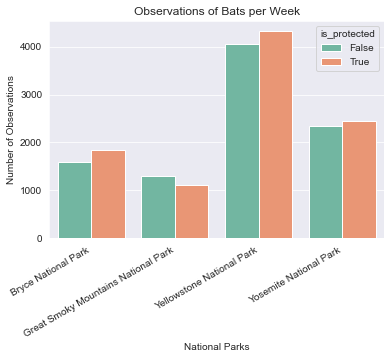

In [137]:
obs_by_park = bat_observations.groupby(['park_name', 'is_protected']).observations.sum()\
.reset_index()
obs_by_park

c = sns.barplot(data = obs_by_park, x = 'park_name', y = 'observations', hue = 'is_protected')
plt.title('Observations of Bats per Week')
plt.xlabel('National Parks')
plt.ylabel('Number of Observations')
c.set_xticklabels(c.get_xticklabels(), rotation = 30, horizontalalignment = 'right')
plt.show()

In [175]:
df = pd.merge(obs, spc, how='left')
df.head()

,scientific_name,park_name,observations,category,common_names,conservation_status
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",No Intervention
1,Neovison vison,Great Smoky Mountains National Park,77,Mammal,American Mink,No Intervention
2,Prunus subcordata,Yosemite National Park,138,Vascular Plant,Klamath Plum,No Intervention
3,Abutilon theophrasti,Bryce National Park,84,Vascular Plant,Velvetleaf,No Intervention
4,Githopsis specularioides,Great Smoky Mountains National Park,85,Vascular Plant,Common Bluecup,No Intervention


park_name
Bryce National Park                     633291
Great Smoky Mountains National Park     474863
Yellowstone National Park              1587641
Yosemite National Park                  949452
Name: observations, dtype: int64


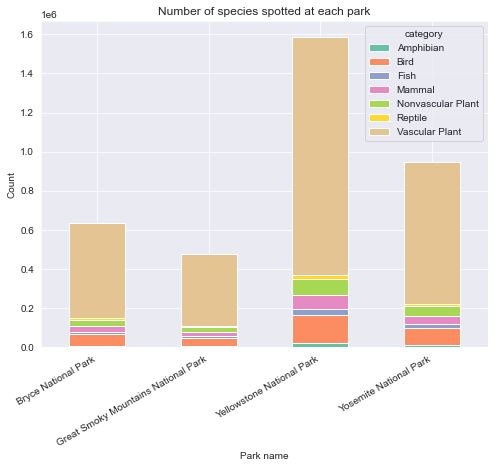

                             park_name                      scientific_name  \
0                  Bryce National Park  Zygodon viridissimus var. rupestris   
1  Great Smoky Mountains National Park  Zygodon viridissimus var. rupestris   
2            Yellowstone National Park  Zygodon viridissimus var. rupestris   
3               Yosemite National Park  Zygodon viridissimus var. rupestris   

   observations  
0          1017  
1           768  
2          2415  
3          1515  


In [173]:
# Which species were spotted the most at each park?
park_species = df.groupby(['park_name'])['observations'].sum()
print(park_species)

df_spc = df.groupby(['park_name', 'category'])['observations'].sum().unstack()

c = df_spc.plot(kind = 'bar', figsize=(8,6), stacked=True)
plt.title('Number of species spotted at each park')
plt.xlabel('Park name')
plt.ylabel('Count')
c.set_xticklabels(c.get_xticklabels(), rotation = 30, horizontalalignment = 'right')
plt.show()

df_all = df.groupby(['park_name', 'scientific_name'])['observations'].sum().reset_index()
print(df_all.groupby(['park_name']).max().reset_index())

# Conclusion
This project was also able to answer some of the questions first posed in the beginning:

- What is the distribution of conservation status for species?
    - The vast majority of species were not part of conservation.(5,633 vs 191)
- Are certain types of species more likely to be endangered?
    - Mammals and Birds had the highest percentage of being in protection.
- Are the differences between species and their conservation status significant?
    - While mammals and Birds did not have significant difference in conservation percentage, mammals and reptiles exhibited a statistically significant difference.
- Which animal is most prevalent and what is their distribution amongst parks?
    - the study found that bats occurred the most number of times and they were most likely to be found in Yellowstone National Park.